In [1]:
# from rendering.renderer_xyz import Renderer
from rendering.renderer_xyz import Renderer
from rendering.model import Model3D
def get_rendering(obj_model,rot_pose,tra_pose, ren):
    ren.clear()
    M=np.eye(4)
    M[:3,:3]=rot_pose
    M[:3,3]=tra_pose
    ren.draw_model(obj_model, M)
    img_r, depth_rend = ren.finish()
    img_r = img_r[:,:,::-1]
    vu_valid = np.where(depth_rend>0)
    bbox_gt = np.array([np.min(vu_valid[0]),np.min(vu_valid[1]),np.max(vu_valid[0]),np.max(vu_valid[1])])
    print(f'vu_valid: {vu_valid}, {len(vu_valid[0])}')
    print(f'depth_rend: {np.min(depth_rend)}, {np.max(depth_rend)}, {depth_rend.shape}')
    print(f'bbox_gt: {bbox_gt}')
#     img_r = img_r[bbox_gt[0]:bbox_gt[2], bbox_gt[1]:bbox_gt[3]]
#     img_r = cv2.resize(img_r, (128,128), interpolation=cv2.INTER_LINEAR)
#     depth_rend = depth_rend[bbox_gt[0]:bbox_gt[2], bbox_gt[1]:bbox_gt[3]]
#     depth_rend = cv2.resize(depth_rend, (128,128), interpolation=cv2.INTER_LINEAR)
    return img_r,depth_rend,bbox_gt

In [2]:
def bbox_shift(img, bbox, shift_pix=(0,0)):    
    # shift_pix: (height shift, width shift)
    img_r = np.zeros_like(img)
    img_r[bbox[0]+shift_pix[0]:bbox[2]+shift_pix[0], bbox[1]+shift_pix[1]:bbox[3]+shift_pix[1]] = img[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    mask = (img_r[...,0]>0).astype(np.uint8)
    return img_r, mask

In [3]:
def find_3d_position(img, K, R, dist, bbox):
    # bbox shape: [y0, x0, y1, x2]
    height, width, channel = img.shape
    h_shift = (bbox[2]+bbox[0])/2 - height/2
    w_shift = (bbox[3]+bbox[1])/2 - width/2
    fX = w_shift*dist
    fY = h_shift*dist
    pix = np.array([fX, fY, dist]).reshape((3,1))
    
    T = np.array([0., 0., dist]).reshape((3,1))
    RT = np.hstack((R,T))
    KRT = np.matmul(K,RT)
    
    point_3d = np.matmul(np.linalg.inv(KRT[...,:3]), pix)
    
    return point_3d

In [4]:
import numpy as np
import json
import os
import cv2
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement
import configparser
from pathlib import Path
config = configparser.ConfigParser()
config.read('./cfg/config.cfg')
lm_path = Path(config['Dataset']['lm'])
model_path = lm_path / 'models' / 'obj_000009.ply'
print(model_path)
model_data = PlyData.read(model_path)
print(model_path)
m_path = str(model_path)
m_path = m_path.replace(os.sep, os.altsep)
print(m_path)
# print(os.altsep)

scene_camera_path = lm_path / 'test' / '000009' / 'scene_camera.json'
scene_gt_path = lm_path / 'test' / '000009' / 'scene_gt.json'
print(scene_camera_path)
print(scene_gt_path)
with open(scene_camera_path) as json_file:
    scene_camera = json.load(json_file)
with open(scene_gt_path) as json_file:
    scene_gt = json.load(json_file)

obj_model = Model3D()
obj_model.load(m_path, scale=0.001)

D:\ImageDataset\PoseDataset\lm_full\models\obj_000009.ply
D:\ImageDataset\PoseDataset\lm_full\models\obj_000009.ply
D:/ImageDataset/PoseDataset/lm_full/models/obj_000009.ply
D:\ImageDataset\PoseDataset\lm_full\test\000009\scene_camera.json
D:\ImageDataset\PoseDataset\lm_full\test\000009\scene_gt.json
Loading obj_000009.ply with vertex colors


INFO: Not setting value for variable vec3 u_light_eye_pos; uniform is not active.
INFO: Not setting value for variable float u_light_ambient_w; uniform is not active.
INFO: Not setting value for variable mat4 u_mv; uniform is not active.


cam_K: [[572.4114    0.      325.2611 ]
 [  0.      573.57043 242.04899]
 [  0.        0.        1.     ]]
(480, 640)
vu_valid: (array([240, 240, 240, ..., 298, 298, 298], dtype=int64), array([375, 376, 377, ..., 373, 374, 375], dtype=int64)), 3060
depth_rend: 0.0, 0.8557326197624207, (480, 640)
bbox_gt: [240 333 298 404]
point_3d: [[-332.91145683]
 [ 731.45123372]
 [-531.49657228]]
rot_pose: [[ 0.99555397 -0.0246045   0.0909228 ]
 [ 0.032046   -0.81922501 -0.57257599]
 [ 0.0885742   0.57294399 -0.81479502]]
tra_pose: [0.06521083 0.03060059 0.82265398]
0.0 0.95294124
(480, 640, 3)
bbox_gt: [240 333 298 404]
img_r.shape: (480, 640, 3)
mask_shift.shape: (480, 640)


Text(0.5, 1.0, 'Mask shifted')

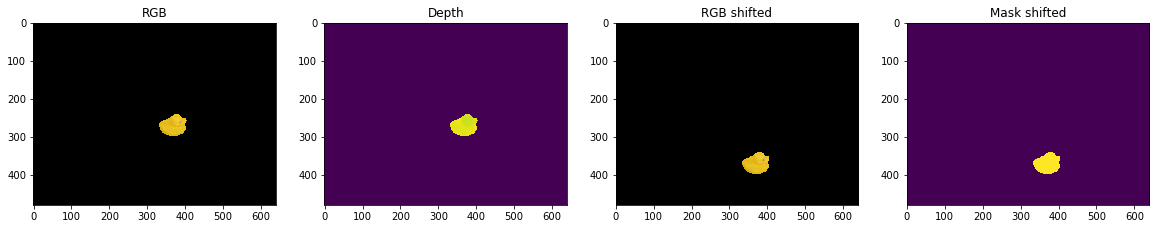

In [5]:
scene_number = '0'
cam_K = scene_camera[scene_number]['cam_K']
cam_R = scene_gt[scene_number][0]['cam_R_m2c']
cam_T = scene_gt[scene_number][0]['cam_t_m2c']
K = np.array(cam_K).reshape((3,3))
R = np.array(cam_R).reshape((3,3))
T = np.array(cam_T).reshape((3,1))
RT = np.hstack((R,T))

cam_K = np.array(cam_K).reshape((3,3))
rot_pose = R
tra_pose = T.reshape(-1) / 1000

ren = Renderer((640, 480),cam_K)
print(f'cam_K: {cam_K}')
print(ren.shape)
# ren.set_cam(cam_K)
img_r,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)

# shift object position
img_shift, mask_shift = bbox_shift(img_r, bbox_gt, shift_pix=(100, 0))

# find 3d point of object center
point_3d = find_3d_position(img_r, K, R, T[2][0], bbox_gt)
print(f'point_3d: {point_3d}')

# img_r = img_r.astype(np.uint8)
print(f'rot_pose: {rot_pose}')
print(f'tra_pose: {tra_pose}')
print(np.min(img_r), np.max(img_r))
print(img_r.shape)
print(f'bbox_gt: {bbox_gt}')
print(f'img_r.shape: {img_r.shape}')
print(f'mask_shift.shape: {mask_shift.shape}')
plt.figure(figsize=(20, 20))
plt.subplot(141)
plt.imshow(img_r) # rendered image from pointcloud model
plt.title('RGB')
plt.subplot(142)
plt.imshow(depth_rend)
plt.title('Depth')
plt.subplot(143)
plt.imshow(img_shift)
plt.title('RGB shifted')
plt.subplot(144)
plt.imshow(mask_shift)
plt.title('Mask shifted')

D:\ImageDataset\PoseDataset\lm_full\train\000009\scene_camera.json
D:\ImageDataset\PoseDataset\lm_full\train\000009\scene_gt.json
vu_valid: (array([ 40,  40,  40, ..., 174, 174, 174], dtype=int64), array([160, 161, 162, ..., 185, 186, 187], dtype=int64)), 13968
depth_rend: 0.0, 0.4334072172641754, (480, 640)
bbox_gt: [ 40 106 174 259]
vu_valid: (array([ 40,  40,  40, ..., 174, 174, 174], dtype=int64), array([313, 314, 315, ..., 323, 324, 325], dtype=int64)), 13618
depth_rend: 0.0, 0.4305626451969147, (480, 640)
bbox_gt: [ 40 255 174 396]
vu_valid: (array([ 40,  40,  40, ..., 174, 174, 174], dtype=int64), array([466, 467, 468, ..., 461, 462, 463], dtype=int64)), 13734
depth_rend: 0.0, 0.42859354615211487, (480, 640)
bbox_gt: [ 40 389 174 535]
vu_valid: (array([193, 193, 193, ..., 313, 313, 313], dtype=int64), array([161, 162, 163, ..., 180, 181, 182], dtype=int64)), 13061
depth_rend: 0.0, 0.4354208707809448, (480, 640)
bbox_gt: [193 106 313 259]
vu_valid: (array([193, 193, 193, ..., 313

Text(0.5, 1.0, 'T: [0.1, 0.1, 0.4]')

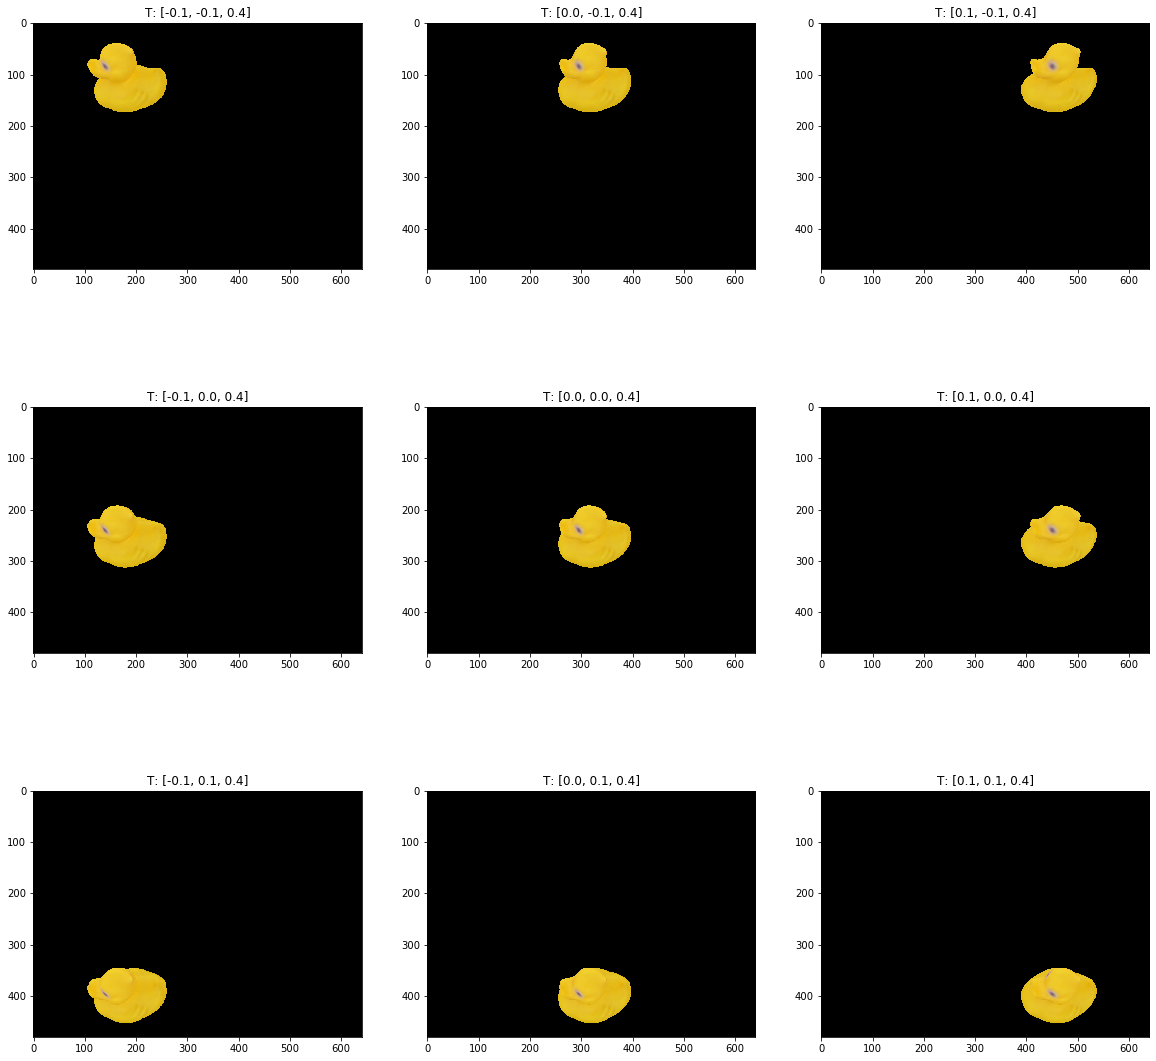

In [25]:
scene_camera_path = lm_path / 'train' / '000009' / 'scene_camera.json'
scene_gt_path = lm_path / 'train' / '000009' / 'scene_gt.json'
print(scene_camera_path)
print(scene_gt_path)
with open(scene_camera_path) as json_file:
    scene_camera = json.load(json_file)
with open(scene_gt_path) as json_file:
    scene_gt = json.load(json_file)

scene_number = '180'
cam_K = scene_camera[scene_number]['cam_K']
cam_R = scene_gt[scene_number][0]['cam_R_m2c']
cam_T = scene_gt[scene_number][0]['cam_t_m2c']
K = np.array(cam_K).reshape((3,3))
R = np.array(cam_R).reshape((3,3))
T = np.array(cam_T).reshape((3,1))
RT = np.hstack((R,T))

cam_K = np.array(cam_K).reshape((3,3))
rot_pose = R
tra_pose = T.reshape(-1) / 1000

ren = Renderer((640, 480),cam_K)

tra_pose = np.array([-0.1, -0.1, 0.4])
img_r1,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)

tra_pose = np.array([0.0, -0.1, 0.4])
img_r2,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)

tra_pose = np.array([0.1, -0.1, 0.4])
img_r3,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)


tra_pose = np.array([-0.1, 0.0, 0.4])
img_r4,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)

tra_pose = np.array([0.0, 0.0, 0.4])
img_r5,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)

tra_pose = np.array([0.1, 0.0, 0.4])
img_r6,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)


tra_pose = np.array([-0.1, 0.1, 0.4])
img_r7,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)

tra_pose = np.array([0.0, 0.1, 0.4])
img_r8,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)

tra_pose = np.array([0.1, 0.1, 0.4])
img_r9,depth_rend,bbox_gt = get_rendering(obj_model,rot_pose,tra_pose,ren)


plt.figure(figsize=(20, 20))
plt.subplot(331)
plt.imshow(img_r1)
plt.title('T: [-0.1, -0.1, 0.4]')
plt.subplot(332)
plt.imshow(img_r2)
plt.title('T: [0.0, -0.1, 0.4]')
plt.subplot(333)
plt.imshow(img_r3)
plt.title('T: [0.1, -0.1, 0.4]')
plt.subplot(334)
plt.imshow(img_r4)
plt.title('T: [-0.1, 0.0, 0.4]')
plt.subplot(335)
plt.imshow(img_r5)
plt.title('T: [0.0, 0.0, 0.4]')
plt.subplot(336)
plt.imshow(img_r6)
plt.title('T: [0.1, 0.0, 0.4]')
plt.subplot(337)
plt.imshow(img_r7)
plt.title('T: [-0.1, 0.1, 0.4]')
plt.subplot(338)
plt.imshow(img_r8)
plt.title('T: [0.0, 0.1, 0.4]')
plt.subplot(339)
plt.imshow(img_r9)
plt.title('T: [0.1, 0.1, 0.4]')